# Spatial Modelling with Pyspatialml

## Example Spatial Prediction using the Meuse Dataset

Here we are using the meuse dataset which is included in the pyspatialml package as an example of performing a spatial model and prediction. We can access the datasets using the `pyspatialml.datasets` module:

In [1]:
from copy import deepcopy
import os
import geopandas as gpd
import numpy as np
from pyspatialml import Raster
from pyspatialml.preprocessing import xy_coordinates, distance_to_corners, distance_to_samples
import pyspatialml.datasets.meuse as ms

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%config InlineBackend.figure_format ='retina'

Various terrain-related predictors have been pre-generated and can be imported by:

In [2]:
predictor_files = ms.predictors
training_pts_file = ms.meuse

## Creating a `Raster` Object

The raster datasets in the meuse module are aligned in terms of their extent and coordinate reference systems. We can 'stack' these into a Raster class so that we can perform machine learning related operations on the set of rasters:

In [3]:
stack = Raster(predictor_files)
stack.names

['chnl_dist',
 'dem',
 'dist',
 'ffreq',
 'landimg2',
 'landimg3',
 'landimg4',
 'mrvbf',
 'rsp',
 'slope',
 'soil',
 'twi']

Pyspatialml implements pandas-style indexing for `Raster` objects, using `Raster.loc` to index by the name of the raster, and `Raster.iloc` to select by index. This method also accepts slices. Label-based indexing is also provided directly by the __getattr_ magic method, i.e. `Raster[name]` or for multiple layers `Raster[(names)]`.

For example we can remove layers from Raster object using the `Raster.drop` method, or by subsetting the raster:

In [4]:
stack.drop('ffreq')

We can store matplotlib cmaps as an attribute within each layer in the Raster:

In [5]:
stack.chnl_dist.cmap = 'RdBu'
stack.dem.cmap = 'terrain'
stack.dist.cmap = 'Reds'
stack.landimg2.cmap = 'Greys'
stack.landimg3.cmap = 'Greys'
stack.landimg4.cmap = 'Greys'
stack.landimg4.cmap = 'Greys'
stack.mrvbf.cmap = 'jet'
stack.rsp.cmap = 'gnuplot2'
stack.slope.cmap = 'PuRd'
stack.soil.cmap = cm.get_cmap('Set2', 3)
stack.twi.cmap = 'coolwarm'

Plot the predictors in the Raster object as a raster matrix:

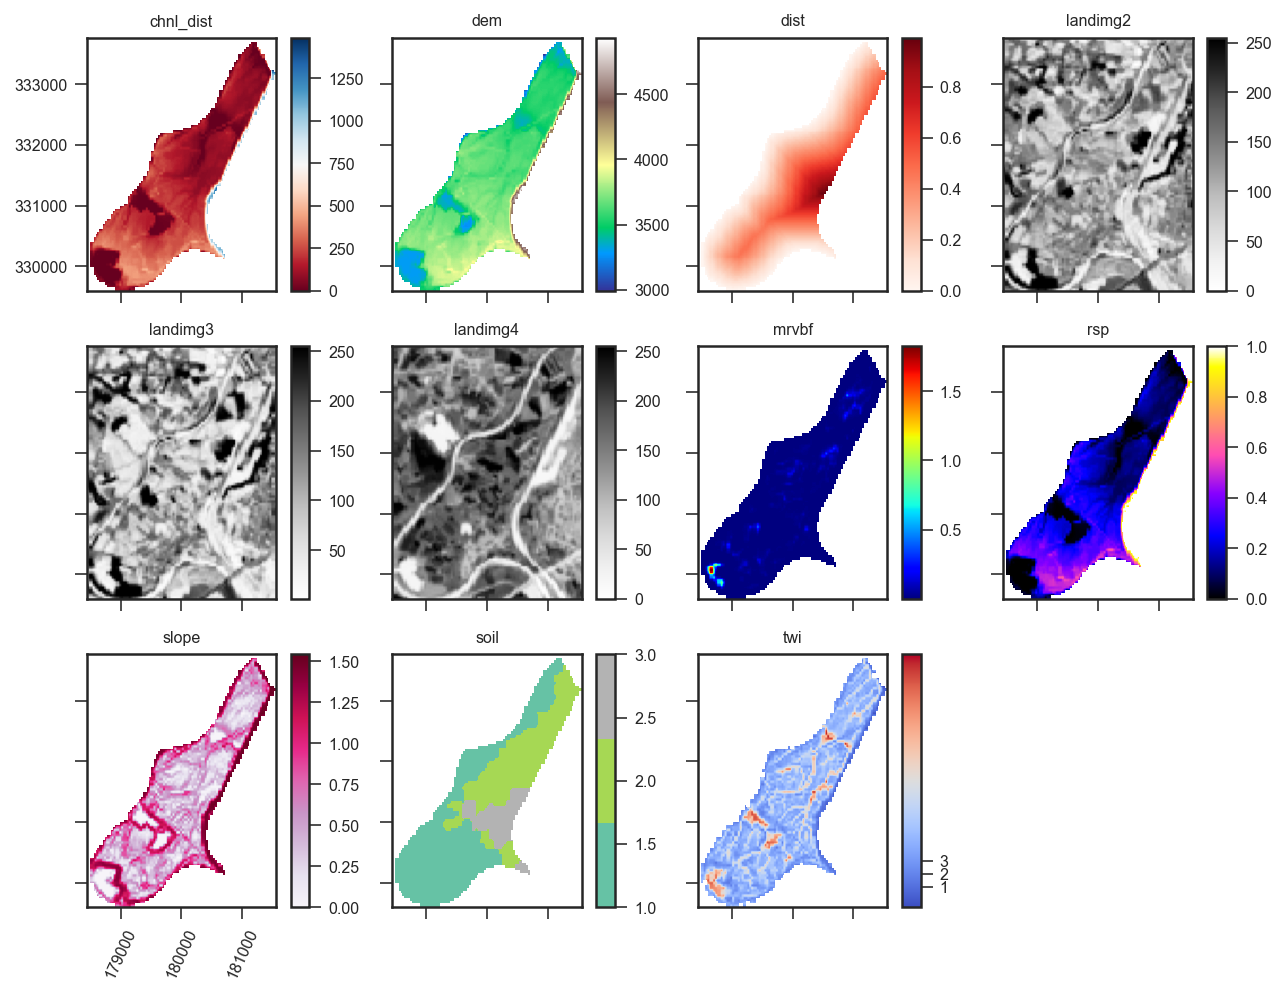

In [6]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

## Feature Engineering

We want the prediction results to be depend on the spatial locations of the training data. So to include spatial information, coordinate grids can be generated and added to the Raster object:

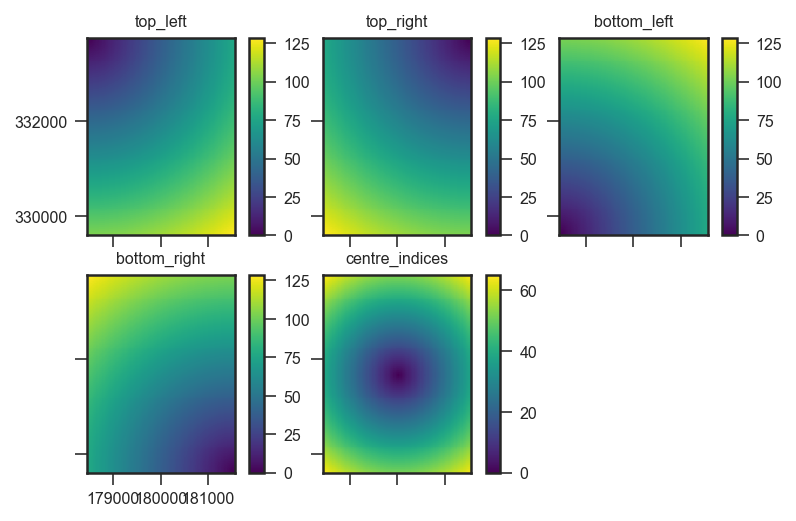

In [7]:
xy_coordinates = xy_coordinates(stack.iloc[0])
edms = distance_to_corners(stack.iloc[0])
edms.plot()
plt.show()

Append them to the Raster object:

In [8]:
stack.append([xy_coordinates, edms])

Plot the new predictors:

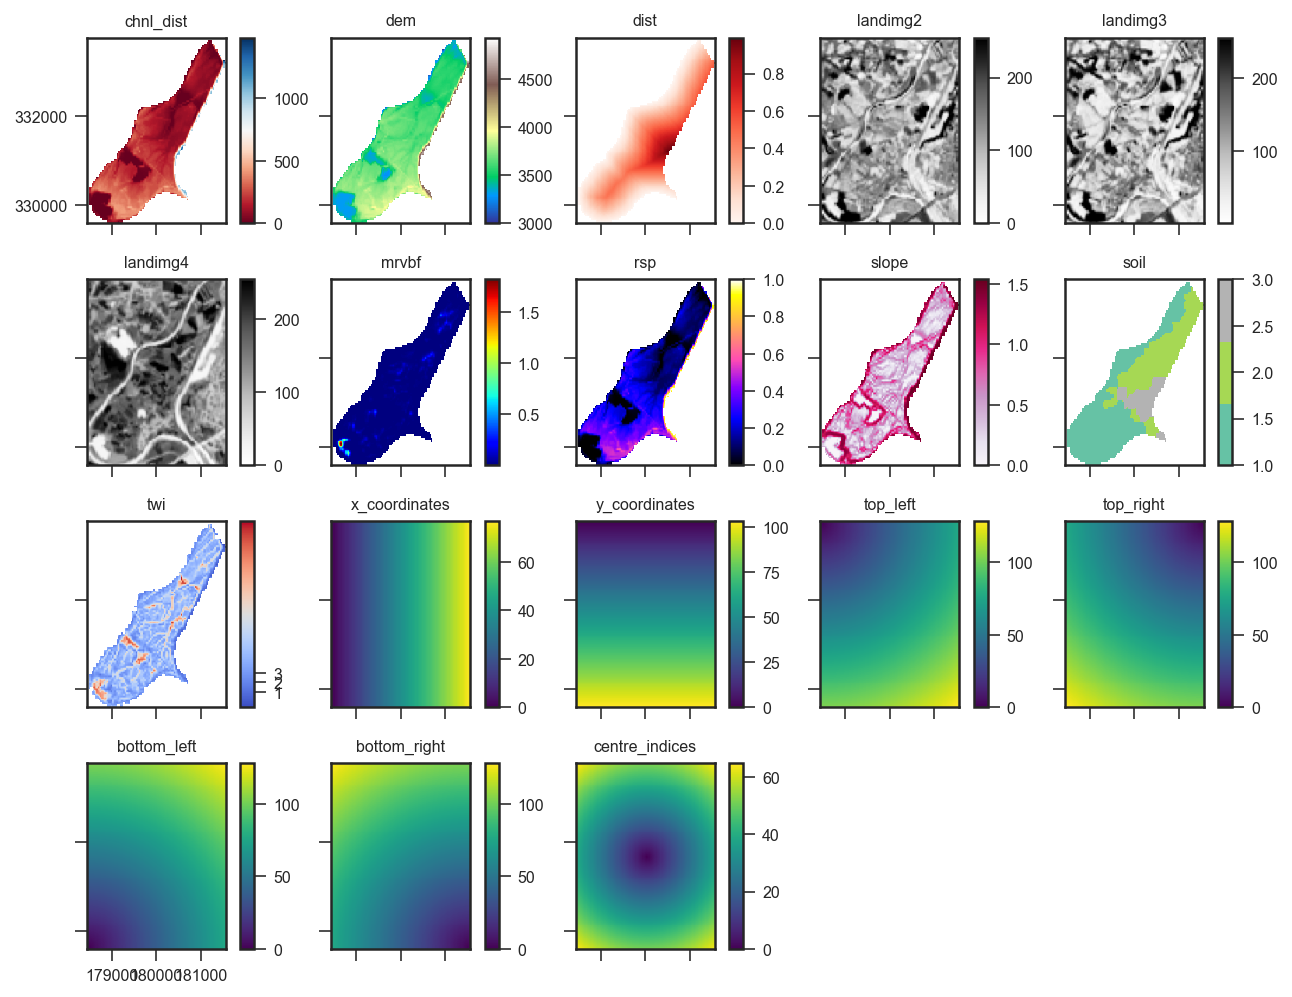

In [9]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

The area that is filled by some of the grids is different. This doesn't matter for the prediction because pixels in the Raster object that include some NaNs in some of the layers will be removed. However, the plots could potentially be given a cleaner look. We can use the Raster.intersect method to fix this:

In [10]:
stack = stack.intersect()

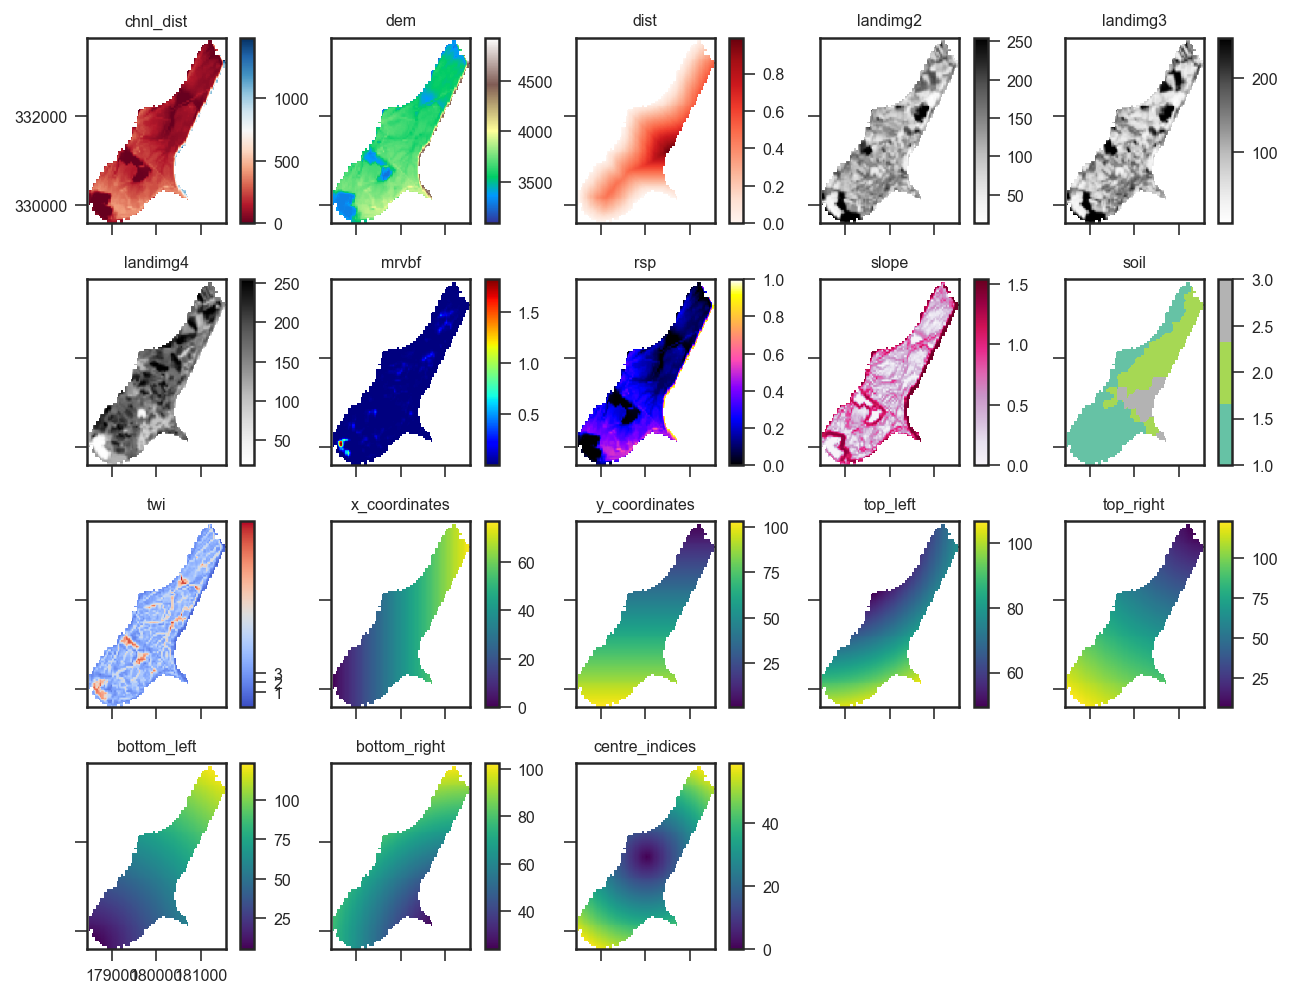

In [11]:
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

## Read the Meuse Dataset

In [12]:
training_pts = gpd.read_file(training_pts_file)
training_pts.head()

cadmium  copper   lead    zinc   elev      dist    om ffreq soil lime  \
0     11.7    85.0  299.0  1022.0  7.909  0.001358  13.6     1    1    1   
1      8.6    81.0  277.0  1141.0  6.983  0.012224  14.0     1    1    1   
2      6.5    68.0  199.0   640.0  7.800  0.103029  13.0     1    1    1   
3      2.6    81.0  116.0   257.0  7.655  0.190094   8.0     1    2    0   
4      2.8    48.0  117.0   269.0  7.480  0.277090   8.7     1    2    0   

  landuse  dist.m                       geometry  
0      Ah    50.0  POINT (181072.000 333611.000)  
1      Ah    30.0  POINT (181025.000 333558.000)  
2      Ah   150.0  POINT (181165.000 333537.000)  
3      Ga   270.0  POINT (181298.000 333484.000)  
4      Ah   380.0  POINT (181307.000 333330.000)

Plot the training points:

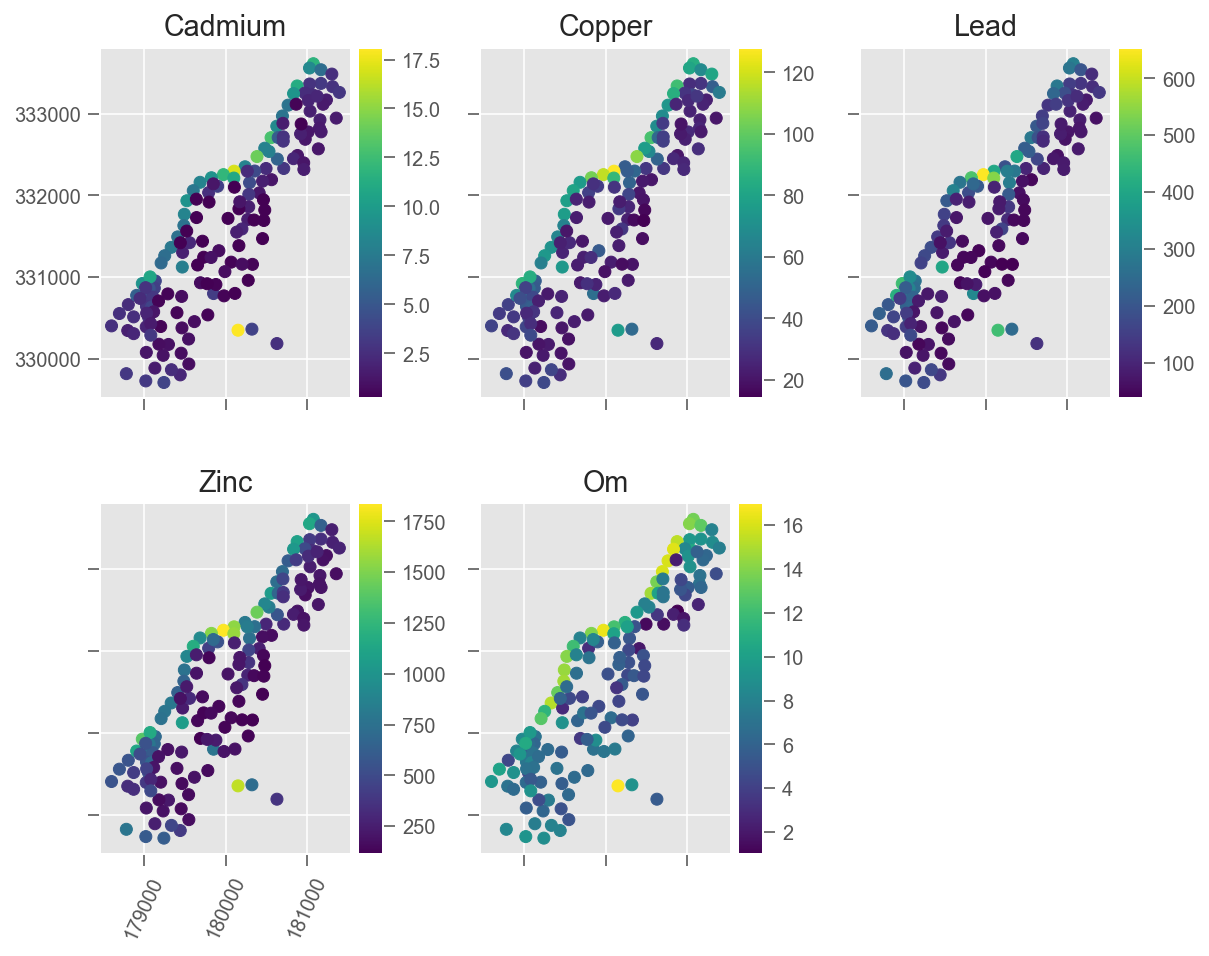

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')

fig, axs = plt.subplots(2, 3, figsize=(8.5, 7))

for i, (ax, target) in enumerate(zip(axs.ravel(), ['cadmium', 'copper', 'lead', 'zinc', 'om'])):
    ax.set_title(target.title())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)
    training_pts.plot(column=target, legend=True, ax=ax, cax=cax, cmap='viridis')
    
    if i != 0:
        ax.set_yticklabels([])
    
    if i != 3:
        ax.set_xticklabels([])
    else:
        ax.tick_params(axis='x', labelrotation=65)
    
fig.delaxes(axs.flatten()[i+1])
plt.tight_layout()
plt.show()

## Extract Raster Values at the Training Point Locations

Pixel values from a Raster object can be extracted using geometries within a geopandas.GeoDataFrame (points, lines, polygons) or by using labelled pixels from another raster with the same dimensions and crs.

By default the extracted values are returned as a geopandas.GeoDataFrame that contains the data and the coordinates of the pixels:

In [14]:
training_df = stack.extract_vector(gdf=training_pts)
training_df = training_df.merge(training_pts.loc[:, ("lead", "cadmium", "copper", "zinc", "om")], left_index=True, right_index=True) 
training_df = training_df.dropna()
training_df.head()

id   chnl_dist     dem      dist  landimg2  landimg3  landimg4  \
0   0    0.000000  3214.0  0.001358      97.0      92.0     192.0   
1   1   79.849854  3402.0  0.012224     160.0     183.0     183.0   
2   2    0.000000  3277.0  0.103029     178.0     209.0     179.0   
3   3  184.743164  3563.0  0.190094     114.0     135.0     152.0   
4   4   16.768555  3406.0  0.277090     133.0     154.0     151.0   

          mrvbf       rsp     slope  ...  top_right  bottom_left  \
0  3.523824e-06  0.000000  1.423307  ...  12.369317   119.268608   
1  9.879866e-06  0.082085  1.286004  ...  13.928389   117.046997   
2  1.340742e-03  0.000000  0.674711  ...  10.295630   119.281181   
3  6.547428e-07  0.192325  1.413479  ...   8.485281   120.208153   
4  1.588824e-03  0.016689  0.531276  ...  11.661903   117.004272   

   bottom_right  centre_indices                       geometry   lead  \
0    100.717430       55.470715  POINT (181072.000 333611.000)  299.0   
1     98.858482       53.235325  POINT (181025.000 333558.000)  277.0   
2     98.412399       55.226807  POINT (181165.000 333537.000)  199.0   
3     97.185387       56.035702  POINT (181298.000 333484.000)  116.0   
4     93.193344       52.801514  POINT (181307.000 333330.000)  117.0   

   cadmium  copper    zinc    om  
0     11.7    85.0  1022.0  13.6  
1      8.6    81.0  1141.0  14.0  
2      6.5    68.0   640.0  13.0  
3      2.6    81.0   257.0   8.0  
4      2.8    48.0   269.0   8.7  

[5 rows x 25 columns]

Alternatively, the data can be returned directly as a tuple of numpy arrays with (geometry_id, data, coordinates):

In [15]:
ids, X, crds = stack.extract_vector(training_pts, return_array=True)

## Fit a Machine Learning Model

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

trans = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), [9])
    ], remainder='passthrough')

et = ExtraTreesRegressor(n_estimators=500, n_jobs=-1)
et = Pipeline([
    ('preproc', trans),
    ('regressor', et)])

X = training_df.loc[:, stack.names]
y = training_df.loc[:, ['lead', 'cadmium', 'copper', 'zinc', 'om']]

et.fit(X, y)

Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  [9])],
                                   verbose=False)),
                ('regressor',
                 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                     criterion='mse', max_depth=None,
    

In [17]:
# cross validate
from sklearn.model_selection import cross_validate
scores = cross_validate(et, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=1)
rmse = np.sqrt(-scores['test_score']).mean()
rmse

111.02695944908199

## Feature Importances

In [18]:
soil_idx = [i for i, name in enumerate(stack.names) if name == 'soil']
ohe_names = deepcopy(stack.names)
ohe_names.insert(soil_idx[0], 'soil1')
ohe_names.insert(soil_idx[0], 'soil2')
ohe_names = np.array(ohe_names)

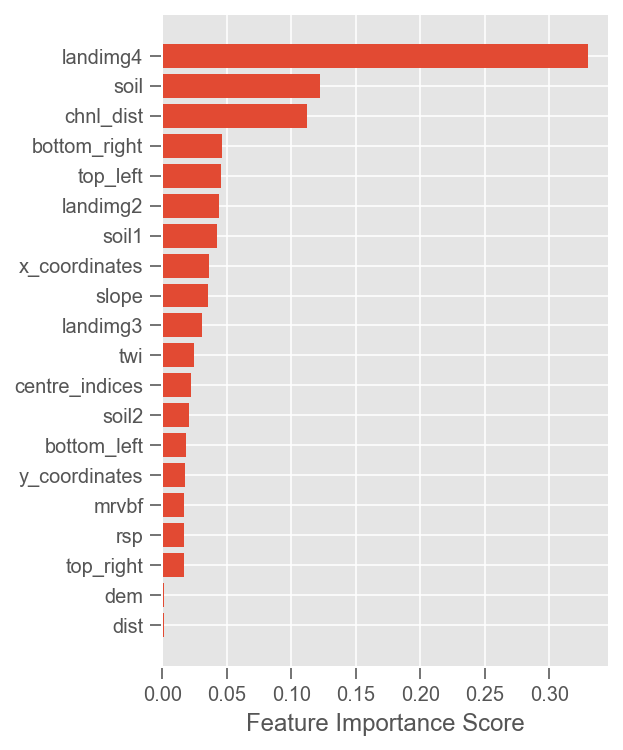

In [19]:
mpl.style.use('ggplot')

fimp = et.named_steps['regressor'].feature_importances_

fig, ax = plt.subplots(figsize=(4, 6))
ax.barh(y=ohe_names[fimp.argsort()], width=fimp[fimp.argsort()])
ax.set_xlabel('Feature Importance Score')
plt.show()

## Prediction on the Raster object

In [20]:
preds = stack.predict(et)
preds.rename({old: new for old, new in zip(preds.names, ['lead', 'cadmium', 'copper', 'zinc', 'om'])})
preds.lead.cmap = 'rainbow'
preds.cadmium.cmap = 'rainbow'
preds.copper.cmap = 'rainbow'
preds.zinc.cmap = 'rainbow'
preds.om.cmap = 'rainbow'

Plot the results:

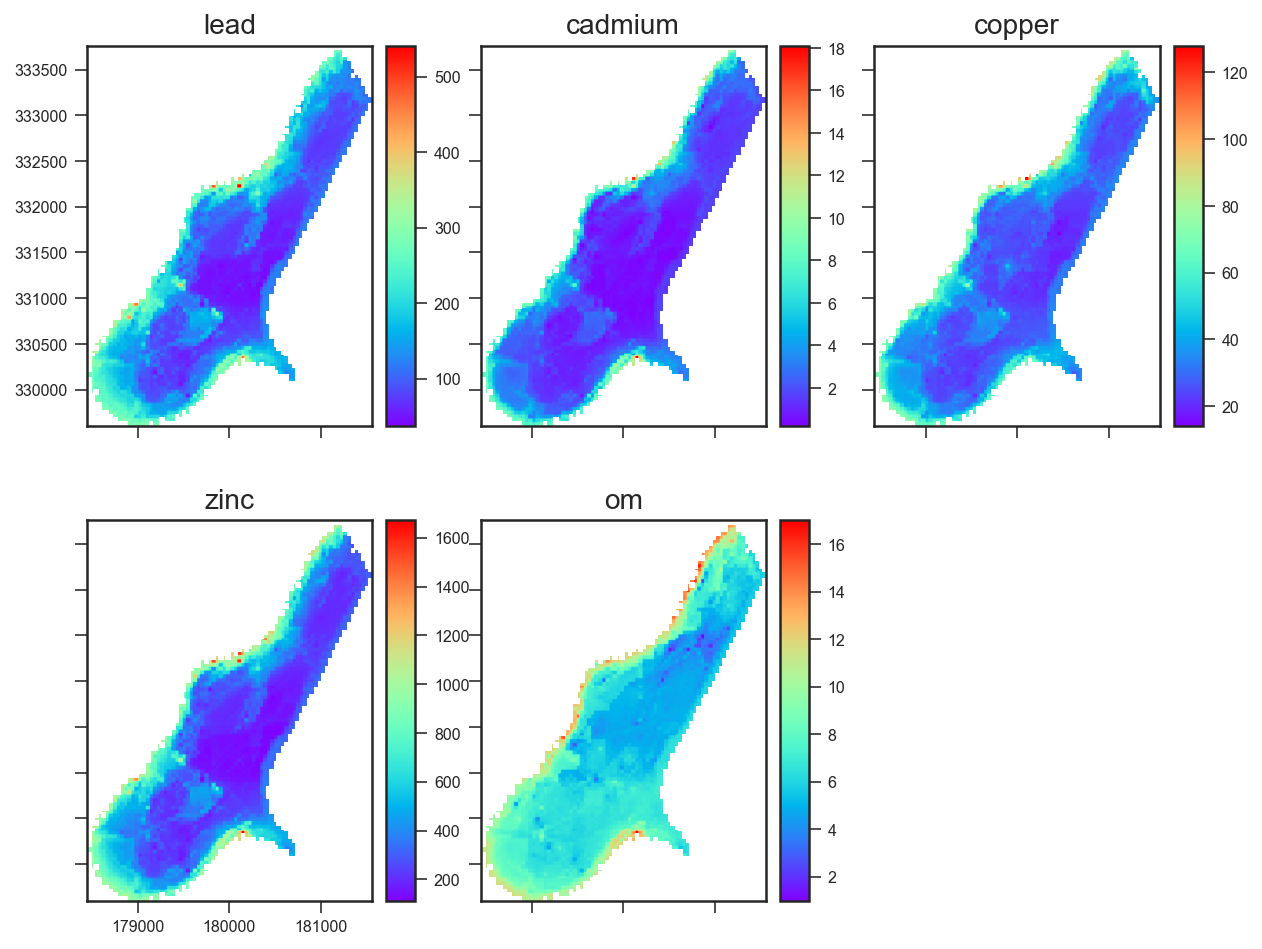

In [21]:
mpl.style.use('seaborn-ticks')
preds.plot(out_shape=(200, 200), title_fontsize=14, figsize=(10, 8))
plt.show()